## 1.导入必要的库和数据

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# 导入必要的库

In [2]:
df = pd.read_excel('数据-YP.xlsx')
# 加载数据

## 2.数据清洗

In [3]:
print(df.dtypes)
# 检查数据

missing_values = df.isnull().sum()
print('缺失值=', missing_values)

Age                           int64
Gender                       object
Real Estate Purchases?       object
Value of Investments ($)      int64
Number of Transactions        int64
Broadband Access?            object
Household Income ($)          int64
Have Children?               object
Unnamed: 8                  float64
Unnamed: 9                   object
dtype: object
缺失值= Age                           0
Gender                        0
Real Estate Purchases?        0
Value of Investments ($)      0
Number of Transactions        0
Broadband Access?             0
Household Income ($)          0
Have Children?                0
Unnamed: 8                  410
Unnamed: 9                  409
dtype: int64


In [4]:
df = df.iloc[:, :8]

In [5]:
def detect_outliers_iqr(column):
    q1, q3 = np.percentile(column, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    # 获取异常值的索引
    outlier = column[(column < lower_bound) | (column > upper_bound)].index
    return outlier

num_columns = ['Age', 'Value of Investments ($)', 'Number of Transactions', 'Household Income ($)']
outliers_detected = {col: detect_outliers_iqr(df[col]) for col in num_columns}

df_temp = df.copy()

for col, outliers in outliers_detected.items():
    if not outliers.empty:
        # 通过排除异常值的索引来创建新的DataFrame
        non_outlier = df_temp.index.difference(outliers)
        df_temp = df_temp.loc[non_outlier]
# 此时df_temp已经排除了所有数值型列中的异常值行

In [6]:
print("临时数据集大小:", df_temp.shape)
# 分析前确认数据集大小

临时数据集大小: (340, 8)


## 3.描述性统计分析

In [7]:
desc_stats = df_temp.describe()
print(desc_stats)

desc_stats.to_csv('description_statistics.csv', index=True)
# 保存描述统计数据csv文件到本地

              Age  Value of Investments ($)  Number of Transactions  \
count  340.000000                340.000000              340.000000   
mean    29.991176              25812.647059                5.394118   
std      3.790601              11566.684385                2.305047   
min     21.000000                  0.000000                0.000000   
25%     28.000000              17775.000000                4.000000   
50%     30.000000              23900.000000                5.000000   
75%     33.000000              32175.000000                7.000000   
max     38.000000              58000.000000               11.000000   

       Household Income ($)  
count            340.000000  
mean           69070.882353  
std            24620.640413  
min            16200.000000  
25%            51475.000000  
50%            65200.000000  
75%            83700.000000  
max           140300.000000  


### 1.年龄分布

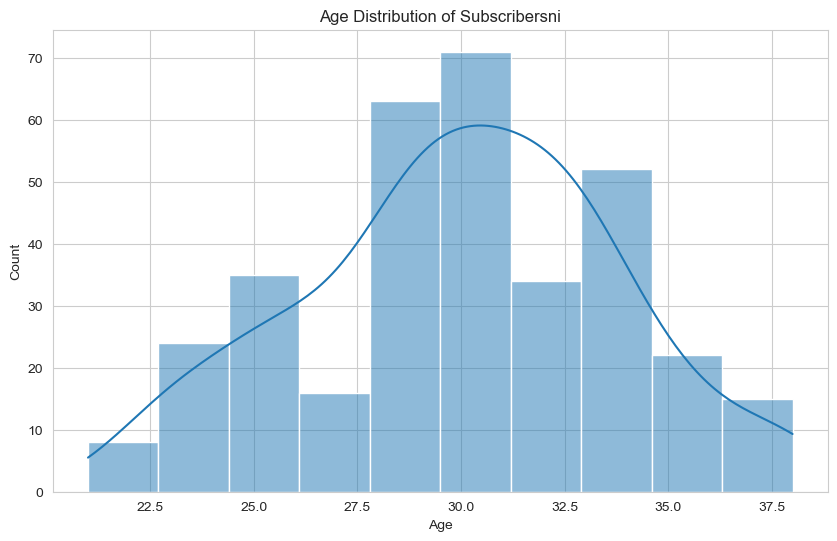

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_temp, x="Age", bins=10, kde=True)
plt.title('Age Distribution of Subscribersni')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

年龄分布趋于正态分布，30岁左右的订阅者最多，年龄范围在20~40岁之间，即大体为青年群体

### 2.性别比例

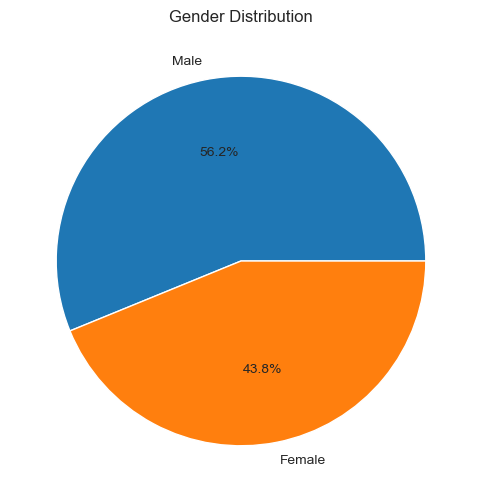

In [9]:
gender_counts = df_temp['Gender'].value_counts(normalize=True)
plt.figure(figsize=(6, 6))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%')
plt.title('Gender Distribution')
plt.show()

由图知，订阅者男性略多

### 3.家庭收入分布

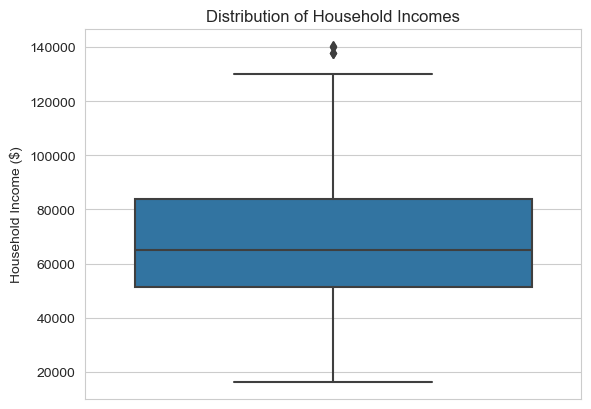

In [10]:
sns.boxplot(y='Household Income ($)', data=df_temp)
plt.title('Distribution of Household Incomes')
plt.show()

家庭收入分布如图

## 4.相关性分析

### 1.对数值变量间相关性分析

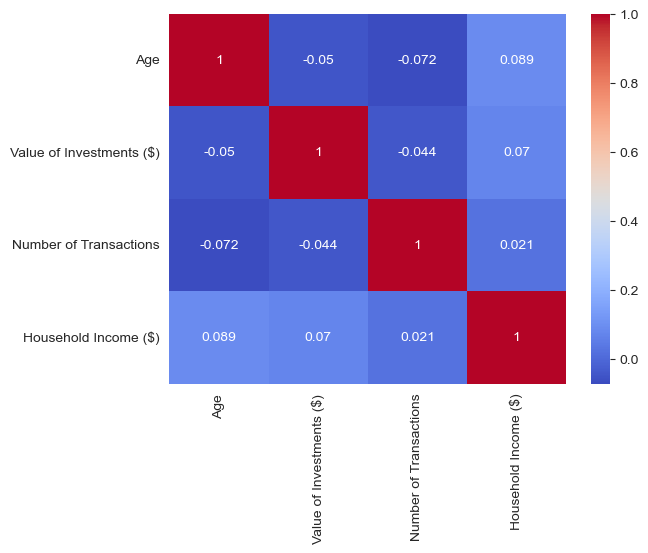

In [11]:
# 绘制热力图显示相关性
corr_matrix = df_temp.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

由图数值变量之间相关性弱，没必要分组分析

### 2.探究购房意愿与投资行为的关系

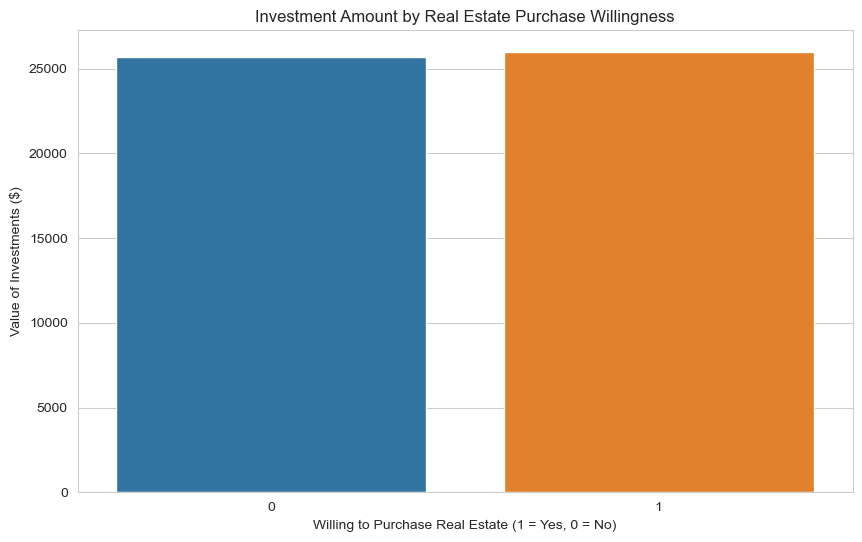

In [12]:
df_temp['Real Estate Purchases_Encoder'] = df_temp['Real Estate Purchases?'].apply(lambda x: 1 if x == 'Yes' else 0)  # 编码购房意愿
plt.figure(figsize=(10, 6))
sns.barplot(x='Real Estate Purchases_Encoder', y='Value of Investments ($)', data=df_temp, ci=None)
plt.title('Investment Amount by Real Estate Purchase Willingness')
plt.xlabel('Willing to Purchase Real Estate (1 = Yes, 0 = No)')
plt.ylabel('Value of Investments ($)')
plt.show()

由图，购房意愿与投资行为没什么关系

### 3.购房意愿与交易次数的关系

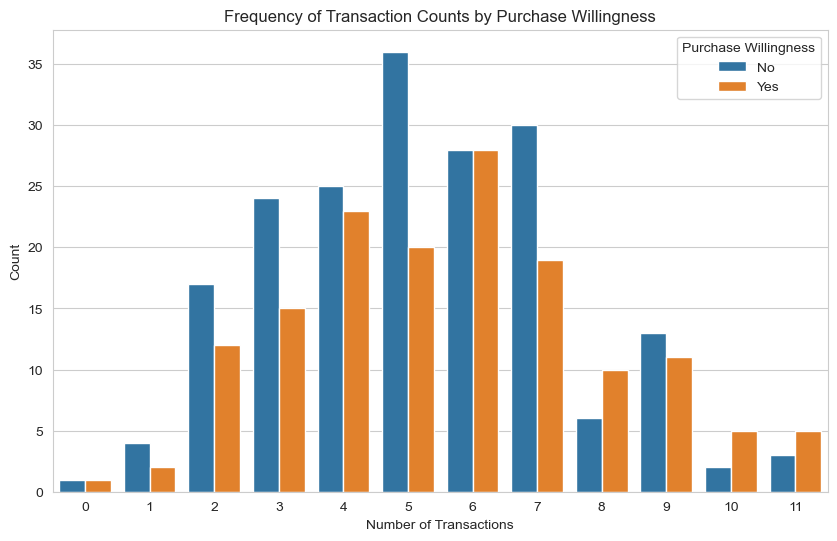

                            mean       std
Real Estate Purchases?                    
No                      5.216931  2.214682
Yes                     5.615894  2.402390


In [13]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Number of Transactions', hue='Real Estate Purchases?', data=df_temp)
plt.title('Frequency of Transaction Counts by Purchase Willingness')
plt.xlabel('Number of Transactions')
plt.ylabel('Count')
plt.legend(title='Purchase Willingness')
plt.show()

grouped = df_temp.groupby('Real Estate Purchases?')['Number of Transactions'].agg(['mean', 'std'])

print(grouped)

由图和表，有购房意愿者的交易次数总体比无购房意愿者更高，交易次数波动性略高

### 4.是否有子女与购房意愿的关系

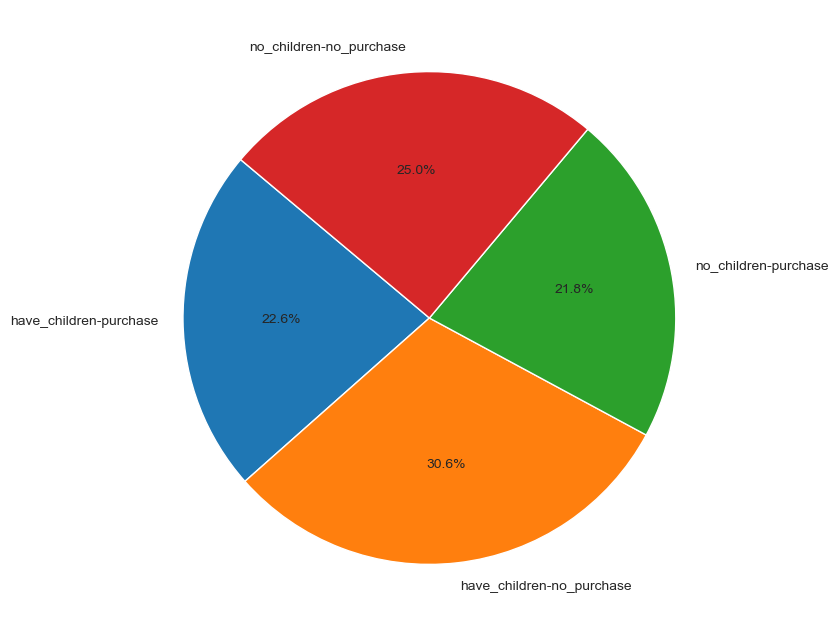

In [14]:
counts = df_temp.groupby(['Have Children?', 'Real Estate Purchases?']).size()

# 提取有无子女且购房（Yes, Yes）与不购房（Yes, No）的计数，假设我们只关注购房意向
children_yes_buying = counts.loc[('Yes', 'Yes')]
children_yes_not_buying = counts.loc[('Yes', 'No')]
children_no_buying = counts.loc[('No', 'Yes')]
children_no_not_buying = counts.loc[('No', 'No')]

# 计算比例
total_counts = counts.sum()
proportions = [children_yes_buying/total_counts, children_yes_not_buying/total_counts,
               children_no_buying/total_counts, children_no_not_buying/total_counts]

# 饼图标签
labels = ['have_children-purchase', 'have_children-no_purchase', 'no_children-purchase', 'no_children-no_purchase']

# 绘制饼图
plt.figure(figsize=(8, 8))
plt.pie(proportions, labels=labels, autopct='%1.1f%%', startangle=140)
plt.show()

由图，有无子女并不影响订阅者倾向于不买房

### 4.性别与家庭收入的关系

Household Income ($)  Low  Medium-Low  Medium  Medium-High  High
Gender                                                          
Female                 19          64      41           19     6
Male                   18          74      55           32    12


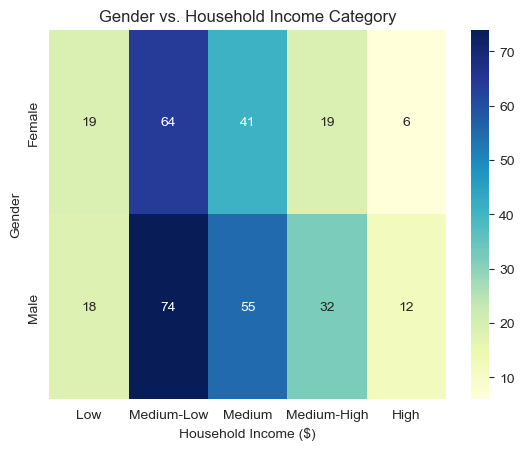

In [15]:
gender_income_cross = pd.crosstab(df_temp['Gender'], pd.cut(df_temp['Household Income ($)'], bins=5, labels=["Low", "Medium-Low", "Medium", "Medium-High", "High"]))
print(gender_income_cross)
sns.heatmap(gender_income_cross, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Gender vs. Household Income Category')
plt.show()

由图，男性的家庭收入要略高，且越高的收入群体男性比例越高